# 3. Monte Carlo Methods

## 3.1 Introduction to Monte Carlo Methods

We have previously looked at the use of Dynamic Programming to solve a basic navigation problem through a gridworld. We modelled our gridworld as a Markov decision process.

Let's brush up on what that means. 
A Markov decision process is defined as a tuple:
$$(\mathcal{S}, \mathcal{A}, P, \mathcal{R}, \gamma)$$

Where: 
- $\mathcal{S}$ is the **state space**.
- $\mathcal{A}$ is the **action space**.
- $P(s'|s,a)$ is the **transition function** - the probability of reaching state $s'$ by taking action $a$ in state $s$. 
- $R(s,a,s')$ is the reward received immediately after taking action $a$ in state $s$. 
- $\gamma$ is a discount factor, which allows us to control how much future rewards matter for the current decision. 

We can leverage this information to derive **Bellman Equations** to find the optimal path through our grid, e.g. through policy evaluation and policy iteration:
$$V^\pi(s)=\sum_a\pi(a|s)\sum_{s'}P(s'|s,a)[R(s,a,s')+\gamma \cdot V^\pi(s')]$$

$$\pi'(s)=\arg\max_a\sum_{s'}P(s'|s,a)[R(s,a,s')+\gamma\cdot V^\pi(s')]$$

Let's move away from our gridworld and consider **real world problems** for a second - take a look at our equations and think about what we **need to know** to leverage dynamic programming to solve an RL problem: 
- $P(s'|s,a)$ **The transition probability**: we need to know the **full transition model** for our environment in advance. 
- $R(s, a, s')$ **The reward function**: we need to know **all possible rewards resulting from all states and actions** in advance. 

These assumptions are **unrealistic in many real-world problems**, so we need to move away from dynamic programming and think of a new approach to solving RL problems. This is where the concept of **Monte Carlo learning** comes in. 

## Monte Carlo Learning
Under a dynamic programming approach, we have **complete information** about the environment in which the agent is operating. This means that we can **compute value functions in advance**. We're not strictly *learning* - it's more like *calculating*. 

**Monte Carlo learning** differs in that we **learn by doing**. By completing episodes and harvesting information about the environment, our agent is progressively learning better ways to approach the problem. 

We can consider a plain gridworld to intuit this. Take a look at the picture below.

In dynamic programming, we have a **complete model of the environment**. Because of this, DP **systematically propagates values across the entire state space**, even for states the agent hasn't visited. Notice in the left-hand plot how values propagate outwards smoothly from the terminal state. This happens because DP uses Bellman equations to iteratively update values everywhere, without needing to *experience* each state. 

Monte Carlo learning operates differently. The agent does *not* have any prior knowledge about the environment, and instead **learns by running episodes and collecting information about the environment**, and then updating values *only for states it has visited*. Take a look at the right-hand plot and how the state values are distributed. This is because updates **only happen in states the agent has actually experienced**. 

With these two differences, we say that DP is a **model-based approach** (leveraging what it knows in advance about the environment - the 'model') and MC is a **model-free approach** (operating without any prior knowledge of the environment - no 'model'). 


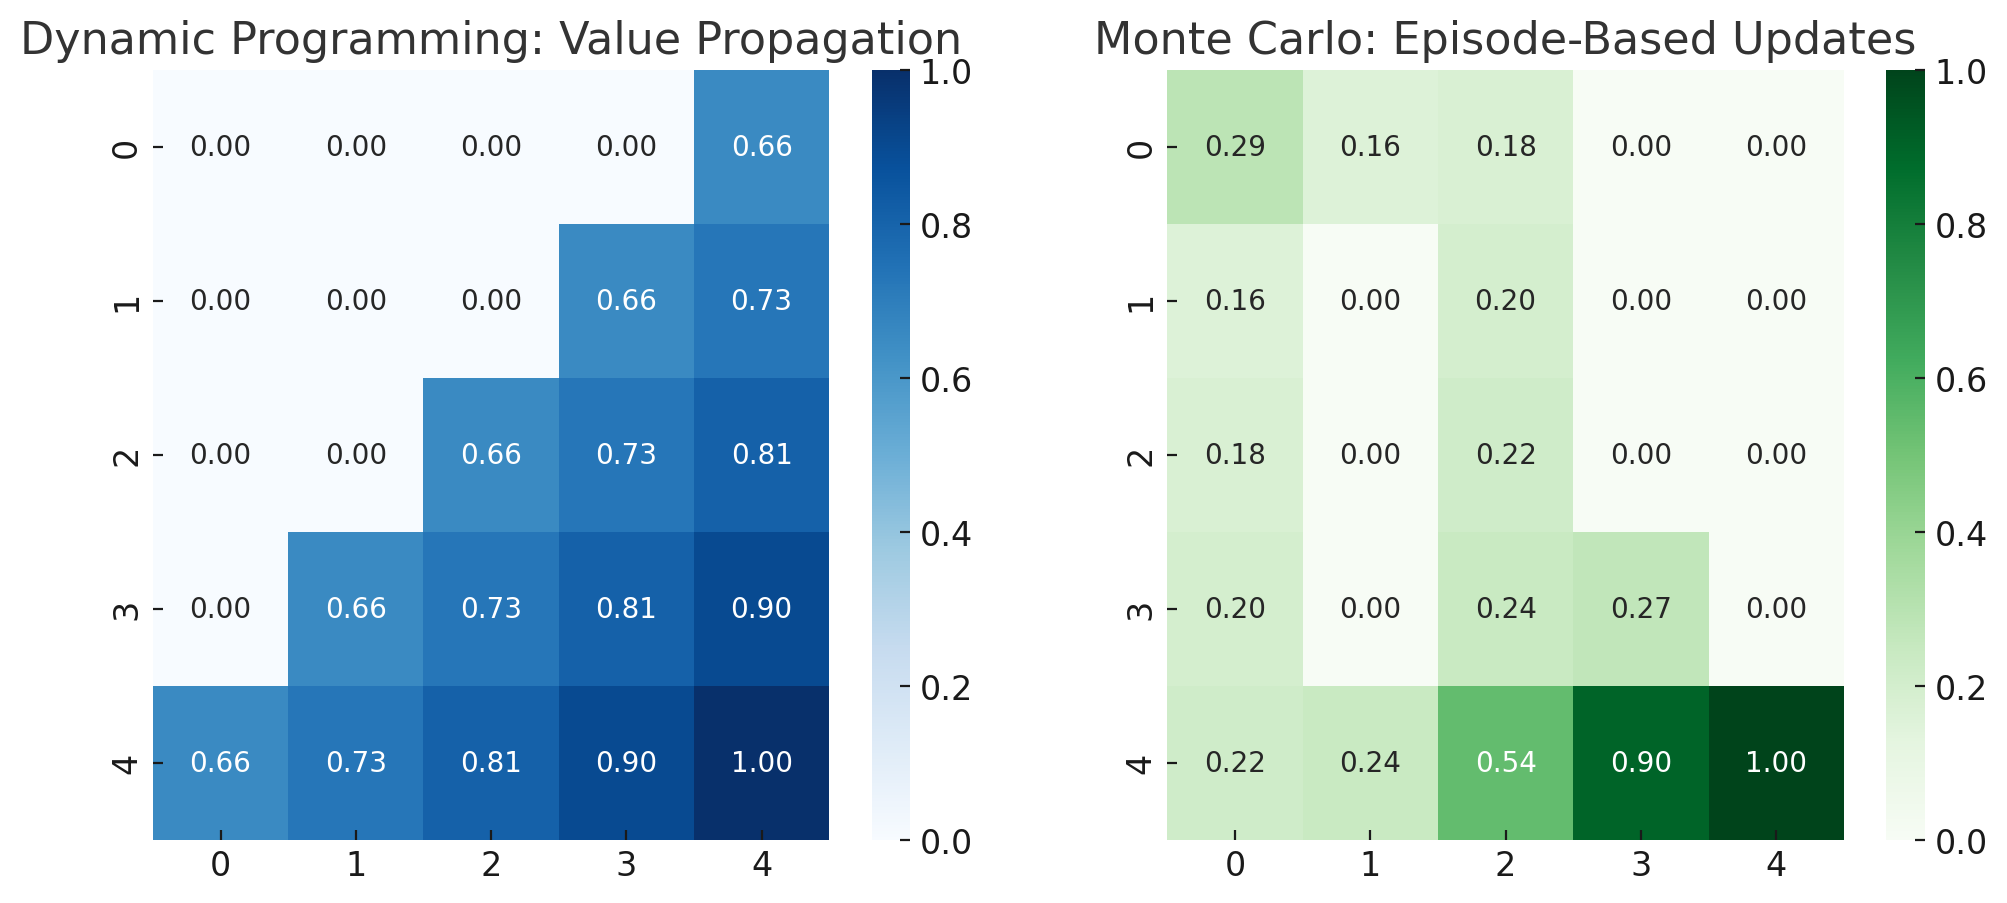

### Monte Carlo Policy Evaluation
In Monte Carlo learning, we still use the concepts of state-values and action-values, but we take a different approach to learning them.

The general approach is as follows: 
1. We initialise a **random policy** (for example, allocating an equal probability to each action in each state).
2. We start the agent in either a random or designated state.
3. We traverse the environment by taking actions based on the defined policy.
4. We store the **($\text{state, action, reward}$)** triplet as we traverse the environment.
5. We continue traversing the environment until we reach a terminal state.

This is defined as **an episode**. The episode is then represented by the **trajectory**, $\tau$, as:
$$(S_0, A_0, R_1, S_1, A_1, R_2, ..., S_T)$$
where $S_T$ is the terminal state. 

Once we have our episode and accompanying trajectory: 
1. We calculate the returns for each state-action pair.
2. We use this information to update:
    - $V(s)$ (Monte Carlo **prediction**),  
    - or $Q(s,a)$ (Monte Carlo **control**). 

## Playing an Episode

We'll go back to our **slippery gridworld** example from the previous notebooks on dynamic programming. 

The gridworld is set up as follows: 
- The grid is the $4 \times 6$ matrix: 
$$\begin{bmatrix}
S& \#&-&-&-&-\\
-& \#&-&-&-&-\\
-&-&-&-&\#&-\\
-&-&-&\#&-&F
\end{bmatrix}
$$
- The action space $\mathcal{A}$ is $\set{\text{Up, Down, Left, Right}}$
- The transition probabilities, $P(s'|s, a)$, are: 
    - $0.8$ that the agent moves in the intended direction
    - $0.1$ that the agent moves to the left of the intended direction
    - $0.1$ that the agent moves to the right of the intended direction
- A **reward** $R$ is only dispensed in the terminal state, $(3,5)$. 

In [61]:
import numpy as np

grid = np.array([
    ['S', '#', '-', '-', '-', '-'],
    ['-', '#', '-', '-', '-', '-'],
    ['-', '-', '-', '-', '#', '-'],
    ['-', '-', '-', '#', '-', 'F']
])

rows, cols = grid.shape
terminal_state = (3, 5)

actions = ['up', 'down', 'left', 'right']
transition_probabilities = [0.8, 0.1, 0.1]

rewards = { terminal_state: 10}

def is_valid(state):
    i, j = state
    return 0 <= i < rows and 0 <= j < cols and grid[i, j] != '#'

def get_possible_moves(state, action):
    i, j = state
    if action == 'up':
        return [(i-1, j), (i, j-1), (i, j+1)] # up, left, right
    elif action == 'down':
        return [(i+1, j), (i, j-1), (i, j+1)] # down, left, right
    elif action == 'left':
        return [(i, j-1), (i-1, j), (i+1, j)] # left, up, down
    elif action == 'right':
        return [(i, j+1), (i-1, j), (i+1, j)] # right, up, down 
    
def get_next_state(state, action):
    possible_moves = get_possible_moves(state, action)

    next_state = possible_moves[np.random.choice(3, p=transition_probabilities)]

    if is_valid(next_state):
        return True, next_state
    else: 
        return False, state
    
def visualise_path():
    grid_viz = grid.copy()

    state = (0, 0)
    path = []
    max_steps = 1000

    for _ in range(max_steps):
        path.append(state)
        if state == terminal_state:
            break

        best_action = get_best_action(state)
        _, next_state = get_next_state(state, best_action)

        if next_state == state:
            pass

        state = next_state
    
    for (i, j) in path:
        if grid_viz[i, j] not in ['S', 'F']:
            grid_viz[i, j] = action_symbols[get_best_action((i, j))]

    for row in grid_viz:
        print(" ".join(row))

action_symbols = {
    "up": "↑",
    "down": "↓",
    "left": "←",
    "right": "→"
}

def get_best_action(state):
    return max(q_values[state], key=q_values[state].get)

Firstly, we'll **initialise a uniform policy**. To do this, we need to set up a dictionary with equal probabilities of selecting each action in each state.

In [62]:
policy = { (i, j): {a: 0.25 for a in actions}
                  for i in range(rows) for j in range(cols)}
policy[(0,0)]

{'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}

We then define a function that allows our agent to traverse the grid and play an episode.

In [63]:
def play_episode(starting_state, policy):
    trajectory = [] # This stores our (state, action, reward) triples for the episode
    finished = False
    state = starting_state

    while not finished:
        step = [] # Stores (state, action, reward) for the current play
        
        # Get the policy for the current state
        action_probabilities = policy[state]
        actions = list(action_probabilities.keys())
        action_probabilities = list(action_probabilities.values())

        # Probabilistically select an action from the policy
        action = np.random.choice(actions, p=action_probabilities)

        # Get the next state when taking the chosen action (probabilistic!)
        is_valid, next_state = get_next_state(state, action)
        
        # Retrieve any immediate rewards (penalise for invalid moves)
        if is_valid:
            reward = rewards.get(next_state, 0)
        else: reward = -1

        # Store state, action, and reward for the current play
        step.append(state)
        step.append(action)
        step.append(reward)

        # Append (state, action, reward) triplet to the trajectory
        trajectory.append(step)

        # End at the terminal state
        if next_state == terminal_state:
            finished = True

        # Update our current state
        state = next_state
    
    return trajectory

In [64]:
np.random.seed(0)

trajectory = play_episode((0,0), policy)
trajectory

[[(0, 0), 'left', -1],
 [(0, 0), 'left', -1],
 [(0, 0), 'down', 0],
 [(1, 0), 'down', -1],
 [(1, 0), 'right', -1],
 [(1, 0), 'right', -1],
 [(1, 0), 'left', 0],
 [(2, 0), 'up', 0],
 [(1, 0), 'up', -1],
 [(1, 0), 'right', 0],
 [(0, 0), 'right', -1],
 [(0, 0), 'down', 0],
 [(1, 0), 'up', 0],
 [(0, 0), 'up', -1],
 [(0, 0), 'left', -1],
 [(0, 0), 'down', 0],
 [(1, 0), 'down', 0],
 [(2, 0), 'up', 0],
 [(1, 0), 'left', -1],
 [(1, 0), 'right', -1],
 [(1, 0), 'down', 0],
 [(2, 0), 'left', -1],
 [(2, 0), 'left', -1],
 [(2, 0), 'up', 0],
 [(1, 0), 'down', 0],
 [(2, 0), 'left', -1],
 [(2, 0), 'right', 0],
 [(2, 1), 'up', -1],
 [(2, 1), 'left', 0],
 [(2, 0), 'down', 0],
 [(3, 0), 'up', 0],
 [(2, 0), 'left', -1],
 [(2, 0), 'up', 0],
 [(1, 0), 'right', -1],
 [(1, 0), 'right', -1],
 [(1, 0), 'right', -1],
 [(1, 0), 'right', -1],
 [(1, 0), 'left', -1],
 [(1, 0), 'down', 0],
 [(2, 0), 'down', 0],
 [(3, 0), 'down', -1],
 [(3, 0), 'up', 0],
 [(2, 0), 'left', -1],
 [(2, 0), 'left', -1],
 [(2, 0), 'left', 

## Calculating Returns
After completing an episode, we then calculate the **return**, $G_t$ for each state-action pair moving *backwards* through the trajectory. 

Recall that $G_t$ is given by: 
$$\begin{align}
G_t&=R_{t+1}+\gamma R_{t+2}+\gamma^2 R_{t+3}+...+\gamma^{T-t-1} R_T\\
 &= \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}
\end{align}$$

We **reverse the trajectory** and then update each state-action pair with the value of its immediate reward **plus** the **discounted return** thereafter: 
$$G_t = R_{t+1} + \gamma G_{t+1}$$

In [65]:
def calculate_returns(trajectory):
    G = 0 
    gamma = 0.9
    returns = []

    for state, action, reward in reversed(trajectory):
        G = reward + gamma * G # Gt = Immediate Reward + Discounted Future Returns, G_t = R_t+1 + gamma * G_t+1
        returns.insert(0, (state, action, G)) # We want to insert at the 0-th index to match our trajectory
    return returns

returns = calculate_returns(trajectory)
returns

[((0, 0), 'left', -5.994937944980626),
 ((0, 0), 'left', -5.549931049978474),
 ((0, 0), 'down', -5.055478944420527),
 ((1, 0), 'down', -5.617198827133918),
 ((1, 0), 'right', -5.130220919037686),
 ((1, 0), 'right', -4.589134354486318),
 ((1, 0), 'left', -3.9879270605403536),
 ((2, 0), 'up', -4.431030067267059),
 ((1, 0), 'up', -4.923366741407843),
 ((1, 0), 'right', -4.359296379342048),
 ((0, 0), 'right', -4.843662643713387),
 ((0, 0), 'down', -4.270736270792652),
 ((1, 0), 'up', -4.745262523102946),
 ((0, 0), 'up', -5.272513914558829),
 ((0, 0), 'left', -4.747237682843143),
 ((0, 0), 'down', -4.16359742538127),
 ((1, 0), 'down', -4.626219361534744),
 ((2, 0), 'up', -5.140243735038605),
 ((1, 0), 'left', -5.711381927820672),
 ((1, 0), 'right', -5.234868808689636),
 ((1, 0), 'down', -4.705409787432928),
 ((2, 0), 'left', -5.228233097147698),
 ((2, 0), 'left', -4.698036774608553),
 ((2, 0), 'up', -4.108929749565059),
 ((1, 0), 'down', -4.5654774995167315),
 ((2, 0), 'left', -5.0727527772

Now that we have computed the **return for each step in the trajectory**, we want to use these returns to **update our estimates of the value function**. 

Recall: 
- The **state-value function**, $V^\pi(s)$: Describes the value of being in a state under a given policy.
- The **action-value function**, $Q^\pi(s,a)$: Describes the value of a given action in a state under a given policy.

The process of improving our estimates of the value function is known as **Monte Carlo Prediction**. Remember that the returns we've calculated for each state-action pair are **under a specified policy**. If we changed our policy, we'd also change our returns. Monte Carlo prediction only seeks to **evaluate the current policy** - we'll improve it later by introducing a new technique.

## Monte Carlo Prediction
There are **two common approaches** we use to estimate the value functions $V^\pi(s)$ and $Q^\pi(s,a)$ from sampled trajectories under a given policy: 
1. **First-Visit Monte Carlo**: We use only the **first occurrence** of a state-action pair within an episode. 
    - Reduces variance, especially in environments with loops.
2. **Every-Visit Monte Carlo**: We use **every occurrence** of a state-action pair within an episode.
    - Uses more data.
    - Can converge faster.

We use these to update our values in one of two ways: 
#### 1. Running Average (Sample mean)
We simply **store all returns and compute the average**. 

**State-value function**:
$$V^\pi(s)=\frac{1}{N(s)}\sum_{i=1}^{N(s)}G_t^{(i)}$$
Where $N(s)$ is the number of visits to the state  **across all episodes**, and $G_t^{(i)}$ is the return observed after the $i$-th visit to state $s$. 

**Action-value function**: 
$$Q^\pi(s,a)=\frac{1}{N(s,a)}\sum_{i=1}^{N(s,a)}G_t^{(i)}$$
Where $N(s,a)$ is the number of times the state-action pair appeared.

For either method, we can use **First-Visit** (include only the *first* time the state/state-action pair appeared in an episode) and **Every-Visit MC** (include *every time* a state/state-action pair appeared in an episode).

This method requires storing **all past returns**, which can be computationally demanding. 

#### 2. Incremental Update Rule
The incremental update rule avoids storing all past returns. Instead, we update incrementally. This allows for **online learning**, where we adjust our estimates after **every episode**.

Recall the first notebook where we computed an incremental sample average of the form:
$$Q(s,a)\leftarrow Q(s,a)+\frac{1}{n}[G_t - Q(s,a)]$$
Equivalently: 
$$V(s)\leftarrow V(s)+\frac{1}{n}[G_t-V(s)]$$
This will yield the **same results** as the previous example with less computational expense. 

This method however does still require tracking how many times $(s)$ or $(s,a)$ has been seen, which can be expensive in environments with lots of states and actions. We also consider environments which **may evolve over time**. We'd want more recent episodes to **contribute more to our value function**. For these purposes we introduce a new parameter, $\alpha \in (0, 1]$, the **learning rate**. $\frac{1}{n}$ can be described as a special case of this learning rate parameter under which every update has equal weighting. We'll continue to use this for now as our environment doesn't evolve.

We then formulate our update rules as follows: 

**State-value function**:
$$V(s)\leftarrow V(s) + \alpha(G_t - V(s))$$

**Action-value function**:
$$Q(s,a)\leftarrow Q(s,a) + \alpha(G_t - Q(s,a))$$

Where: 
- $G_t-Q(s,a)$ or $G_t-V(s)$ is the **error** between what actually happened and what we expected.
- $\alpha$ scales how strongly we react to that error.
- The update nudges our estimate **towards** the new data, but not all the way.
- This gives us a weighted average over time, where recent data has more influence.


Let's put this into practice. We'll use the **Incremental Update Rule** to update a set of **action-values**. 

We firstly need to initialise our action-value dictionary.

In [66]:
q_values = { (i, j): {a: 0.0 for a in actions}
                  for i in range(rows) for j in range(cols)}
q_values[(0,0)]

{'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 0.0}

We also want to keep track of how many times a state-action pair has been visited across episodes, so we also define a 'visits' dictionary. 

In [67]:
visits = { (i, j): {a: 0 for a in actions}
                  for i in range(rows) for j in range(cols)}
visits[(0,0)]

{'up': 0, 'down': 0, 'left': 0, 'right': 0}

In [ ]:
def update_q_values(q_values, visits, trajectory, method='every-visit'):
    # Store unique visited states
    visited = set()

    # Loop over each step in the trajectory
    for (state, action, G) in trajectory:

        # First visit: only use the first occurrence in episode to update Q-value
        if method == 'first-visit' and (state, action) in visited:
            continue

        # Define alpha as 1/n
        visits[state][action] += 1
        alpha = 1 / visits[state][action]

        # Apply the incremental update rule
        q_values[state][action] += alpha * (G - q_values[state][action])

        visited.add((state, action))

    return q_values

We can then have our agent play 10 episodes, updating the Q-values at each step.

In [69]:
episodes = 10

for i in range(episodes):
    trajectory = play_episode(starting_state=(0,0), policy=policy)
    returns = calculate_returns(trajectory)
    q_values = update_q_values(q_values, visits, returns, method='every-visit')

q_values

{(0, 0): {'up': -5.6407363987956485,
  'down': -4.297973140236714,
  'left': -5.310483602148956,
  'right': -5.410146688099093},
 (0, 1): {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 0.0},
 (0, 2): {'up': -3.4866308035756397,
  'down': -2.022271359652346,
  'left': -3.5611531241313488,
  'right': -2.2456418099271978},
 (0, 3): {'up': -3.3572240236592834,
  'down': -2.104483334410036,
  'left': -2.486069103937668,
  'right': -2.0543257247662448},
 (0, 4): {'up': -3.0720449253529445,
  'down': -1.0351414694014198,
  'left': -2.5485329640874195,
  'right': -1.433646647335922},
 (0, 5): {'up': -1.691728607709369,
  'down': 0.13287782699850575,
  'left': -1.3155010202418227,
  'right': -1.9079532697970154},
 (1, 0): {'up': -4.696813168833503,
  'down': -3.7106963398237887,
  'left': -4.805314292740105,
  'right': -4.5411117946930855},
 (1, 1): {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 0.0},
 (1, 2): {'up': -2.8501413665678124,
  'down': -2.373913895995368,
  'left': -2.93868526341255

Monte Carlo prediction works well in small action and state spaces as it will likely sample each state-action pair at least once under our uniform policy. This allows us to choose the best action in each state to visualise a path through our small grid.

In [70]:
visualise_path()

S # - - ↓ -
↓ # - → → ↓
→ → → ↑ # ↓
- - - # - F


## Monte Carlo Control
When we start to increase state or action spaces, the chance of randomly discovering optimal actions becomes vanishingly small. Some states or actions may *never* be visited, meaning that value estimates remain uninformed or just wrong. Without sufficient exploration, the agent risks **converging to a sub-optimal policy**.

For our gridworld, that may mean selecting a path that **does** lead to the terminal state, but **does not take the shortest path**. 

While Monte Carlo **prediction** allows us to evaluate how good a given policy is, prediction alone does **not** tell us how to improve our decisions - it simply tells us **how good our current decisions are**. 

Consider our current policy: the agent will select 'Up', 'Down', 'Left', or 'Right' with equal probability in every single state. Now imagine our state space was ten times the size. The probability of randomly stumbling across the terminal state becomes increasingly small (this is where random initialisation can come in handy!) but also the probability of visiting every single state and sampling each action also becomes increasingly small. We can't address this problem if we don't gradually alter the policy to take a more concerted path towards the terminal state. 

This is where Monte Carlo **Control** comes in by introducing **policy improvement**. After we have estimated $Q^\pi(s,a)$, we improve our policy by choosing actions that yield higher returns. We then use this **improved policy** to generate new episodes. 

However, if we only selected the action with the highest known returns *every time*, we risk converging to a sub-optimal policy - what if there are better choices that the agent has not yet explored? This is why we also introduce an element of **exploration**. To do this, we use a technique we saw in the first notebook - $\epsilon$-greedy selection:
- Choose the best known action with probability $1-\epsilon$
- Occasionally explore other actions with probability $\epsilon$
This ensures that we have the opportunity to sample new actions while still allowing the policy to improve over time. 